In [17]:
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

%matplotlib inline

In [2]:
# load data
with open('reviews_Movies_and_TV_5.json') as f:
    raw_data = [eval(x) for x in f.readlines()]
    

In [3]:
raw_data[0]

{'asin': '0005019281',
 'helpful': [0, 0],
 'overall': 4.0,
 'reviewText': 'This is a charming version of the classic Dicken\'s tale.  Henry Winkler makes a good showing as the "Scrooge" character.  Even though you know what will happen this version has enough of a change to make it better that average.  If you love A Christmas Carol in any version, then you will love this.',
 'reviewTime': '02 26, 2008',
 'reviewerID': 'ADZPIG9QOCDG5',
 'reviewerName': 'Alice L. Larson "alice-loves-books"',
 'summary': 'good version of a classic',
 'unixReviewTime': 1203984000}

In [7]:
with open('ratings.txt', 'w') as f:
    f.write('reviewerID,asin,overall\n')
    for d in raw_data:
        f.write('{},{},{}\n'.format(d['reviewerID'], d['asin'], d['overall']))
        

In [8]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [9]:
def preprocess(data):
    all_words = []
    all_reviews = []
    for r in data:
        r = r['reviewText'].lower()
        r = ''.join([c for c in r if c not in punctuation])
        review = []
        for w in r.split():
            if w not in stop_words:
                all_words.append(w)
                review.append(w)
        review = ' '.join(review)
        all_reviews.append(review)
    return all_reviews, all_words

In [10]:
reviews, all_words = preprocess(raw_data)

In [13]:
lengths = []
for r in reviews:
    lengths.append(len(r.split()))

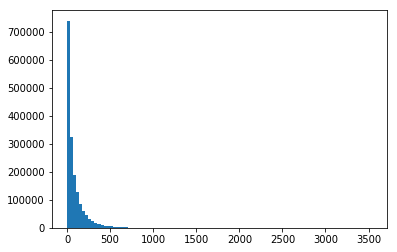

In [15]:
plt.hist(lengths, bins=100)
plt.show()

In [18]:
print 'total words: ', len(all_words)
words_freq = nltk.FreqDist(all_words)
print 'unique words: ', len(words_freq)

total words:  146204758
unique words:  2680396


In [19]:
vocab_size = 5000
vocab = [x[0] for x in words_freq.most_common(vocab_size)]
vocab_set = set(vocab)
vocab2indx = dict(zip(vocab, range(vocab_size)))

In [21]:
all_users = set()
all_items = set()
for d in raw_data:
    all_users.add(d['reviewerID'])
    all_items.add(d['asin'])
print len(all_users)
print len(all_items)

123960
50052


In [22]:
user2indx = dict(zip(all_users, range(len(all_users))))
item2indx = dict(zip(all_items, range(len(all_items))))

In [27]:
def get_user_item(d):
    return (user2indx[d['reviewerID']], item2indx[d['asin']])
user_item = [get_user_item(d) for d in raw_data] 

In [28]:
np.save('user_item.npy', user_item)

In [11]:
def feature(review):
    for w in review.split():
        if w in vocab_set:
            feat.append(vocab2indx[w])
    return feat

In [13]:
reviews_feats = [feature(r) for r in reviews]
ratings = [r['overall'] for r in raw_data]

In [14]:
np.save('processed_data.npy', {'features': reviews_feats,
                               'ratings': ratings})

In [34]:
# load data
data = np.load('processed_data.npy').item()

In [ ]:
reviews_feats = data['features']
ratings = data['ratings']

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import optimizers
from keras.callbacks import TensorBoard

In [16]:
max_review_length = 500
X = sequence.pad_sequences(reviews_feats, maxlen=max_review_length)

In [32]:
train_size = 1600000
X_train = X[:train_size, :]
y_train = np.array(ratings[:train_size])
X_test = X[train_size:, :]
y_test = np.array(ratings[train_size:])
val_ratio = 0.05

In [30]:
print 'Training data size: {}'.format(X_train.shape)
print 'Test data size: {}'.format(X_test.shape)

Training data size: (1600000, 500)
Test data size: (97533, 500)


In [22]:
# define MLP model

embedding_size = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation=None))

optim = optimizers.Adam(lr=0.001,
                        decay=0.001)
model.compile(loss='mse',
              optimizer='adam',
              metrics = ['mse'])
tensorboard = TensorBoard(log_dir='./logs', write_graph=True)

In [33]:
model.fit(X_train, y_train,
          batch_size=64,
          epochs=5,
          callbacks=[tensorboard],
          validation_split=val_ratio,
          shuffle=True,
          verbose=1,
          )

Train on 1520000 samples, validate on 80000 samples
Epoch 1/5
 461696/1520000 [========>.....................] - ETA: 21:06 - loss: 0.7885 - mean_squared_error: 0.7885

KeyboardInterrupt: 